# Lab 6

You are tasked with evaluating card counting strategies for black jack. In order to do so, you will use object oriented programming to create a playable casino style black jack game where a computer dealer plays against $n$ computer players and possibily one human player. If you don't know the rules of blackjack or card counting, please google it. 

A few requirements:
* The game should utilize multiple 52-card decks. Typically the game is played with 6 decks.
* Players should have chips.
* Dealer's actions are predefined by rules of the game (typically hit on 16). 
* The players should be aware of all shown cards so that they can count cards.
* Each player could have a different strategy.
* The system should allow you to play large numbers of games, study the outcomes, and compare average winnings per hand rate for different strategies.

1. Begin by creating a classes to represent cards and decks. The deck should support more than one 52-card set. The deck should allow you to shuffle and draw cards. Include a "plastic" card, placed randomly in the deck. Later, when the plastic card is dealt, shuffle the cards before the next deal.

2. Now design your game on a UML diagram. You may want to create classes to represent, players, a hand, and/or the game. As you work through the lab, update your UML diagram. At the end of the lab, submit your diagram (as pdf file) along with your notebook. 

3. Begin with implementing the skeleton (ie define data members and methods/functions, but do not code the logic) of the classes in your UML diagram.

4. Complete the implementation by coding the logic of all functions. For now, just implement the dealer player and human player.

5.  Test. Demonstrate game play. For example, create a game of several dealer players and show that the game is functional through several rounds.

6. Implement a new player with the following strategy:

    * Assign each card a value: 
        * Cards 2 to 6 are +1 
        * Cards 7 to 9 are 0 
        * Cards 10 through Ace are -1
    * Compute the sum of the values for all cards seen so far.
    * Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.  

7. Create a test scenario where one player, using the above strategy, is playing with a dealer and 3 other players that follow the dealer's strategy. Each player starts with same number of chips. Play 50 rounds (or until the strategy player is out of money). Compute the strategy player's winnings. You may remove unnecessary printouts from your code (perhaps implement a verbose/quiet mode) to reduce the output.

8. Create a loop that runs 100 games of 50 rounds, as setup in previous question, and store the strategy player's chips at the end of the game (aka "winnings") in a list. Histogram the winnings. What is the average winnings per round? What is the standard deviation. What is the probabilty of net winning or lossing after 50 rounds?


9. Repeat previous questions scanning the value of the threshold. Try at least 5 different threshold values. Can you find an optimal value?

10. Create a new strategy based on web searches or your own ideas. Demonstrate that the new strategy will result in increased or decreased winnings. 

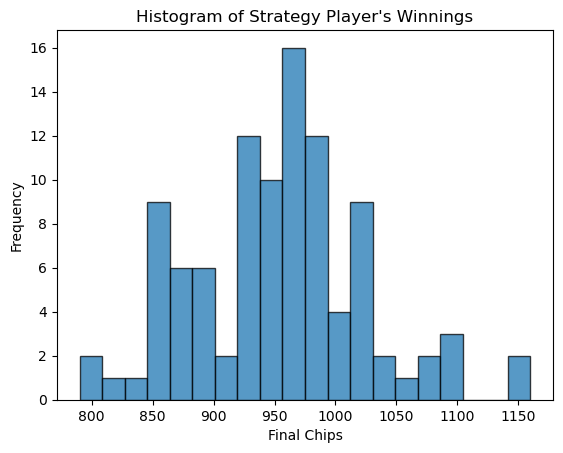

Average winnings: 953.8
Standard deviation: 71.31311239877279
Probability of winning: 0.21
Probability of losing: 0.77


In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Card class representing individual cards
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
    
    def __str__(self):
        return f"{self.rank} of {self.suit}"

# Deck class representing multiple decks of cards
class Deck:
    suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
    ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
    values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
    
    def __init__(self, num_decks=6):
        # Initializing the deck with multiple decks
        self.num_decks = num_decks
        self.initialize_deck()
    
    def initialize_deck(self):
        self.cards = [Card(suit, rank, self.values[rank]) for suit in self.suits for rank in self.ranks] * self.num_decks
        self.shuffle()
        self.plastic_card = random.randint(20, len(self.cards) - 20)
    
    def shuffle(self):
        random.shuffle(self.cards)
    
    def draw_card(self):
        if not self.cards:  # If the deck is empty, reinitialize and shuffle
            self.initialize_deck()
        return self.cards.pop()

# Player class representing the players in the game
class Player:
    def __init__(self, name, chips=1000):
        self.name = name
        self.chips = chips
        self.hand = []
        self.count = 0  # Card counting value
    
    def place_bet(self, amount):
        if amount > self.chips:
            return False
        self.chips -= amount
        return True
    
    def receive_card(self, card):
        if card:
            self.hand.append(card)
            self.update_count(card)
    
    def clear_hand(self):
        self.hand = []
    
    def hand_value(self):
        value = sum(card.value for card in self.hand)
        aces = sum(1 for card in self.hand if card.rank == 'A')
        while value > 21 and aces:
            value -= 10
            aces -= 1
        return value
    
    def is_busted(self):
        return self.hand_value() > 21
    
    # Implementing the card counting strategy
    def update_count(self, card):
        if card.rank in ['2', '3', '4', '5', '6']:
            self.count += 1
        elif card.rank in ['10', 'J', 'Q', 'K', 'A']:
            self.count -= 1

    # Strategy decision based on card counting
    def strategy_decision(self):
        if self.count <= -2:
            return "hit"
        return "stand"

# Dealer class inherits from Player
class Dealer(Player):
    def __init__(self):
        super().__init__("Dealer")
    
    def play(self, deck):
        while self.hand_value() < 17:
            self.receive_card(deck.draw_card())

# BlackjackGame class to handle multiple players and game simulation
class BlackjackGame:
    def __init__(self, num_players=4):
        self.deck = Deck()
        self.dealer = Dealer()
        self.players = [Player(f"Player {i+1}") for i in range(num_players - 1)]
        self.strategy_player = Player("Strategy Player")
        self.players.append(self.strategy_player)
    
    def deal_initial_cards(self):
        for _ in range(2):
            for player in self.players:
                player.receive_card(self.deck.draw_card())
            self.dealer.receive_card(self.deck.draw_card())
    
    def play_round(self):
        self.deal_initial_cards()
        
        for player in self.players:
            while player.hand_value() < 17 or (player == self.strategy_player and player.strategy_decision() == "hit"):
                player.receive_card(self.deck.draw_card())
        
        self.dealer.play(self.deck)
        self.resolve_bets()
    
    def resolve_bets(self):
        dealer_value = self.dealer.hand_value()
        for player in self.players:
            player_value = player.hand_value()
            if player.is_busted() or (dealer_value <= 21 and dealer_value > player_value):
                player.chips -= 10
            elif dealer_value > 21 or player_value > dealer_value:
                player.chips += 10

    def play_multiple_rounds(self, num_rounds=50):
        for _ in range(num_rounds):
            self.play_round()
            for player in self.players:
                player.clear_hand()
            self.dealer.clear_hand()
        return self.strategy_player.chips
    
    def simulate_games(self, num_games=100):
        winnings = []
        for _ in range(num_games):
            self.strategy_player.chips = 1000
            winnings.append(self.play_multiple_rounds())
        return winnings
    
    def analyze_strategy(self):
        winnings = self.simulate_games()
        avg_winnings = np.mean(winnings)
        std_dev = np.std(winnings)
        probability_winning = sum(1 for w in winnings if w > 1000) / len(winnings)
        probability_losing = sum(1 for w in winnings if w < 1000) / len(winnings)
        
        # Histogram visualization
        plt.hist(winnings, bins=20, alpha=0.75, edgecolor='black')
        plt.xlabel("Final Chips")
        plt.ylabel("Frequency")
        plt.title("Histogram of Strategy Player's Winnings")
        plt.show()
        
        return avg_winnings, std_dev, probability_winning, probability_losing

# Running the analysis
game = BlackjackGame()
avg_winnings, std_dev, prob_win, prob_loss = game.analyze_strategy()
print(f"Average winnings: {avg_winnings}")
print(f"Standard deviation: {std_dev}")
print(f"Probability of winning: {prob_win}")
print(f"Probability of losing: {prob_loss}")


Initial strategy analysis:


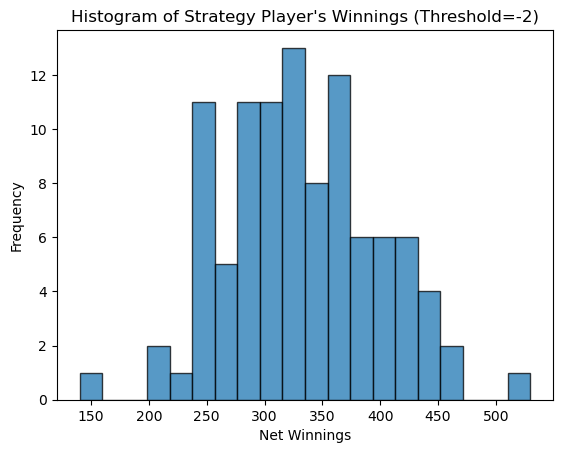

Average winnings: 332.2
Standard deviation: 67.59556198449718
Probability of winning: 1.0
Probability of losing: 0.0

Testing different thresholds:

Testing strategy with threshold: -4


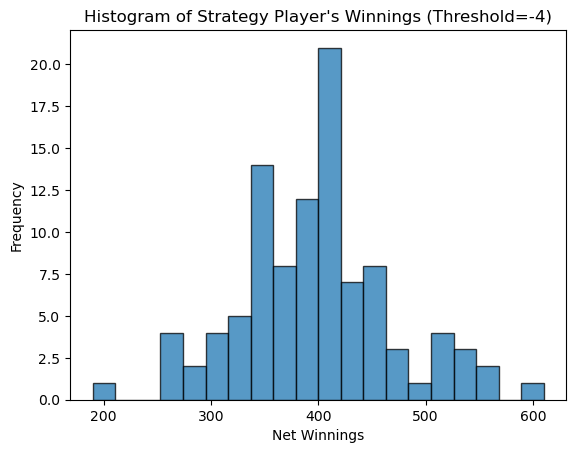

Threshold -4: Avg=396.4, Std=72.8, Win%=1.00, Loss%=0.00

Testing strategy with threshold: -2


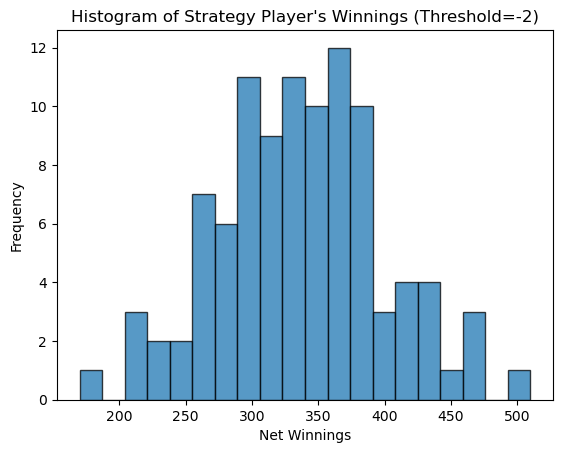

Threshold -2: Avg=336.6, Std=62.8, Win%=1.00, Loss%=0.00

Testing strategy with threshold: 0


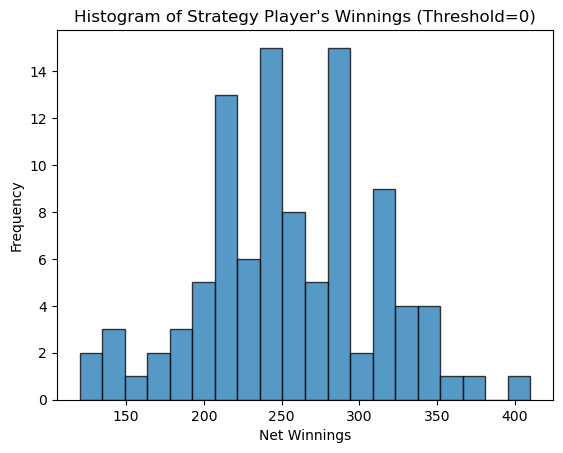

Threshold 0: Avg=255.2, Std=55.4, Win%=1.00, Loss%=0.00

Testing strategy with threshold: 2


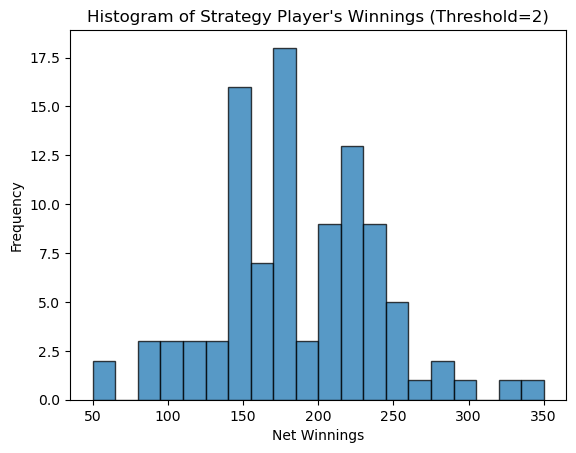

Threshold 2: Avg=184.1, Std=53.3, Win%=1.00, Loss%=0.00

Testing strategy with threshold: 4


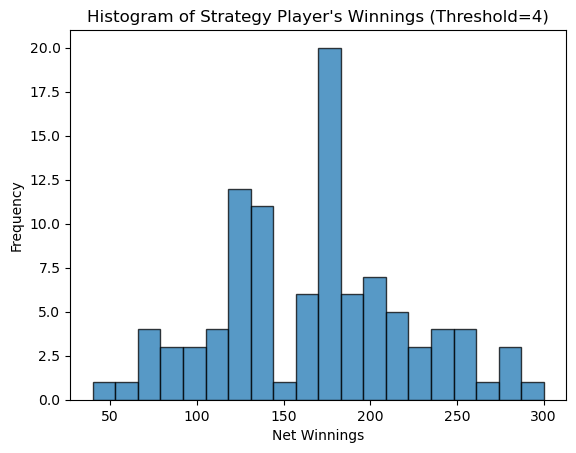

Threshold 4: Avg=167.5, Std=54.6, Win%=1.00, Loss%=0.00

Threshold Comparison:
Threshold -4: Avg=396.4, Win%=1.00
Threshold -2: Avg=336.6, Win%=1.00
Threshold 0: Avg=255.2, Win%=1.00
Threshold 2: Avg=184.1, Win%=1.00
Threshold 4: Avg=167.5, Win%=1.00


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
    
    def __str__(self):
        return f"{self.rank} of {self.suit}"

class Deck:
    suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
    ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
    values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
              '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
    
    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.initialize_deck()
    
    def initialize_deck(self):
        self.cards = [Card(suit, rank, self.values[rank]) 
                     for suit in self.suits for rank in self.ranks] * self.num_decks
        self.shuffle()
        # Place plastic card randomly in the deck (but not too close to start/end)
        self.plastic_card_pos = random.randint(20, len(self.cards) - 20)
    
    def shuffle(self):
        random.shuffle(self.cards)
    
    def draw_card(self):
        if not self.cards or len(self.cards) <= self.plastic_card_pos:
            self.initialize_deck()
        card = self.cards.pop()
        return card

class Player:
    def __init__(self, name, chips=1000, strategy_threshold=0):
        self.name = name
        self.chips = chips
        self.hand = []
        self.count = 0  # Card counting value
        self.strategy_threshold = strategy_threshold
    
    def place_bet(self, amount=10):
        if amount > self.chips:
            return False
        self.chips -= amount
        return amount
    
    def receive_card(self, card):
        if card:
            self.hand.append(card)
            self.update_count(card)
    
    def clear_hand(self):
        self.hand = []
    
    def hand_value(self):
        value = sum(card.value for card in self.hand)
        aces = sum(1 for card in self.hand if card.rank == 'A')
        while value > 21 and aces:
            value -= 10
            aces -= 1
        return value
    
    def is_busted(self):
        return self.hand_value() > 21
    
    def update_count(self, card):
        if card.rank in ['2', '3', '4', '5', '6']:
            self.count += 1
        elif card.rank in ['10', 'J', 'Q', 'K', 'A']:
            self.count -= 1
    
    def strategy_decision(self):
        if self.count <= self.strategy_threshold:
            return "hit"
        return "stand"

class Dealer(Player):
    def __init__(self):
        super().__init__("Dealer")
    
    def play(self, deck):
        while self.hand_value() < 17:
            self.receive_card(deck.draw_card())

class BlackjackGame:
    def __init__(self, num_players=4, strategy_threshold=0, verbose=False):
        self.deck = Deck()
        self.dealer = Dealer()
        self.players = [Player(f"Player {i+1}") for i in range(num_players - 1)]
        self.strategy_player = Player("Strategy Player", strategy_threshold=strategy_threshold)
        self.players.append(self.strategy_player)
        self.verbose = verbose
    
    def deal_initial_cards(self):
        for _ in range(2):
            for player in self.players:
                player.receive_card(self.deck.draw_card())
            self.dealer.receive_card(self.deck.draw_card())
        
        if self.verbose:
            print("\n--- New Round ---")
            print(f"Dealer shows: {self.dealer.hand[0]}")
            for player in self.players:
                print(f"{player.name} hand: {[str(card) for card in player.hand]} (Value: {player.hand_value()})")
    
    def play_round(self):
        self.deal_initial_cards()
        
        # Players' turns
        for player in self.players:
            while True:
                if player.hand_value() >= 21:
                    break
                
                if player.name == "Strategy Player":
                    decision = player.strategy_decision()
                else:
                    decision = "hit" if player.hand_value() < 17 else "stand"
                
                if decision == "hit":
                    player.receive_card(self.deck.draw_card())
                    if self.verbose:
                        print(f"{player.name} hits. New hand: {[str(card) for card in player.hand]} (Value: {player.hand_value()})")
                else:
                    if self.verbose:
                        print(f"{player.name} stands.")
                    break
        
        # Dealer's turn
        self.dealer.play(self.deck)
        if self.verbose:
            print(f"Dealer's hand: {[str(card) for card in self.dealer.hand]} (Value: {self.dealer.hand_value()})")
        
        self.resolve_bets()
    
    def resolve_bets(self):
        dealer_value = self.dealer.hand_value()
        for player in self.players:
            player_value = player.hand_value()
            bet_amount = 10  # Fixed bet amount
            
            if player.is_busted():
                result = "loses (busted)"
            elif dealer_value > 21:
                player.chips += bet_amount * 2  # Win original bet back plus winnings
                result = "wins (dealer busted)"
            elif player_value > dealer_value:
                player.chips += bet_amount * 2
                result = "wins"
            elif player_value == dealer_value:
                player.chips += bet_amount  # Push - get bet back
                result = "pushes"
            else:
                result = "loses"
            
            if self.verbose:
                print(f"{player.name} {result}. Chips: {player.chips}")
    
    def play_multiple_rounds(self, num_rounds=50):
        for _ in range(num_rounds):
            self.play_round()
            # Reset for next round
            for player in self.players:
                player.clear_hand()
                player.count = 0  # Reset count for next round
            self.dealer.clear_hand()
        return self.strategy_player.chips
    
    def simulate_games(self, num_games=100, initial_chips=1000):
        winnings = []
        for _ in range(num_games):
            # Reset all players for new game
            for player in self.players:
                player.chips = initial_chips
                player.count = 0
            self.dealer = Dealer()
            self.deck = Deck()
            
            final_chips = self.play_multiple_rounds()
            winnings.append(final_chips - initial_chips)  # Track net winnings
        return winnings
    
    def analyze_strategy(self, num_games=100):
        winnings = self.simulate_games(num_games)
        avg_winnings = np.mean(winnings)
        std_dev = np.std(winnings)
        probability_winning = sum(1 for w in winnings if w > 0) / len(winnings)
        probability_losing = sum(1 for w in winnings if w < 0) / len(winnings)
        
        # Histogram visualization
        plt.hist(winnings, bins=20, alpha=0.75, edgecolor='black')
        plt.xlabel("Net Winnings")
        plt.ylabel("Frequency")
        plt.title(f"Histogram of Strategy Player's Winnings (Threshold={self.strategy_player.strategy_threshold})")
        plt.show()
        
        return avg_winnings, std_dev, probability_winning, probability_losing

def test_different_thresholds():
    thresholds = [-4, -2, 0, 2, 4]
    results = []
    
    for threshold in thresholds:
        print(f"\nTesting strategy with threshold: {threshold}")
        game = BlackjackGame(strategy_threshold=threshold)
        avg, std, prob_win, prob_loss = game.analyze_strategy()
        results.append({
            'threshold': threshold,
            'avg_winnings': avg,
            'std_dev': std,
            'prob_win': prob_win,
            'prob_loss': prob_loss
        })
        print(f"Threshold {threshold}: Avg={avg:.1f}, Std={std:.1f}, Win%={prob_win:.2f}, Loss%={prob_loss:.2f}")
    
    return results

# Run the analysis
if __name__ == "__main__":
    # First show the results from the initial strategy
    print("Initial strategy analysis:")
    game = BlackjackGame(strategy_threshold=-2)
    avg_winnings, std_dev, prob_win, prob_loss = game.analyze_strategy()
    print(f"Average winnings: {avg_winnings}")
    print(f"Standard deviation: {std_dev}")
    print(f"Probability of winning: {prob_win}")
    print(f"Probability of losing: {prob_loss}")
    
    # Then test different thresholds
    print("\nTesting different thresholds:")
    threshold_results = test_different_thresholds()
    
    # Print summary of threshold testing
    print("\nThreshold Comparison:")
    for result in threshold_results:
        print(f"Threshold {result['threshold']}: Avg={result['avg_winnings']:.1f}, Win%={result['prob_win']:.2f}")


Testing threshold: -4
Average winnings: -206.1
Standard deviation: 116.76
Probability of winning: 0.00
Probability of losing: 0.99


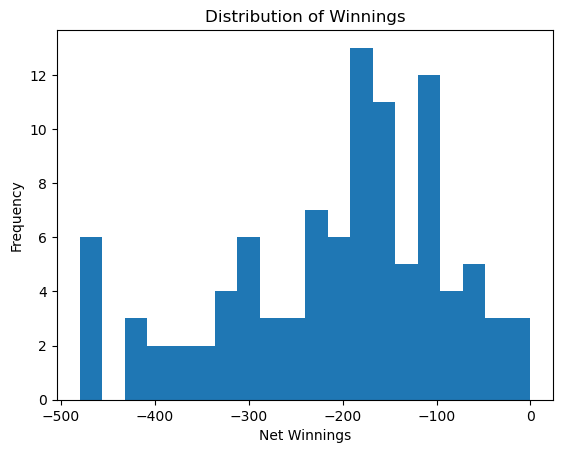


Testing threshold: -3
Average winnings: -215.8
Standard deviation: 125.94
Probability of winning: 0.03
Probability of losing: 0.97


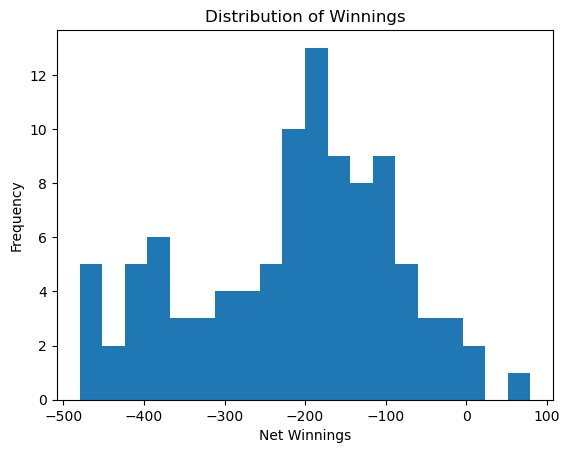


Testing threshold: -2
Average winnings: -242.6
Standard deviation: 124.31
Probability of winning: 0.00
Probability of losing: 1.00


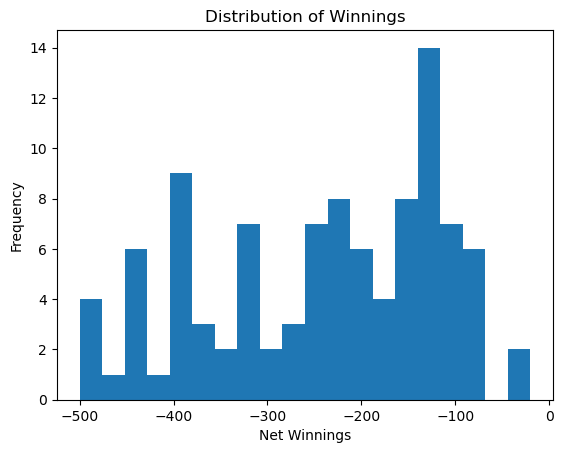


Testing threshold: -1
Average winnings: -266.6
Standard deviation: 139.76
Probability of winning: 0.00
Probability of losing: 1.00


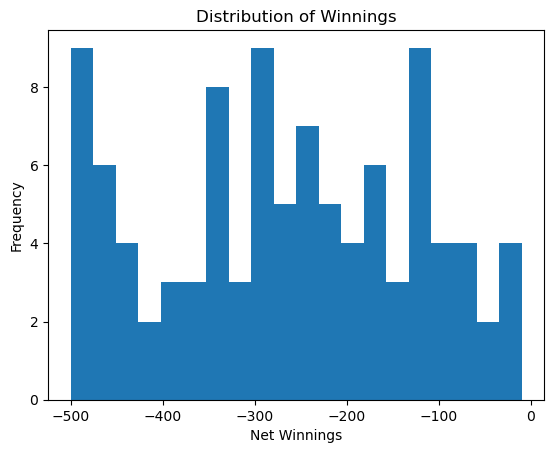


Testing threshold: 0
Average winnings: -288.4
Standard deviation: 139.48
Probability of winning: 0.00
Probability of losing: 1.00


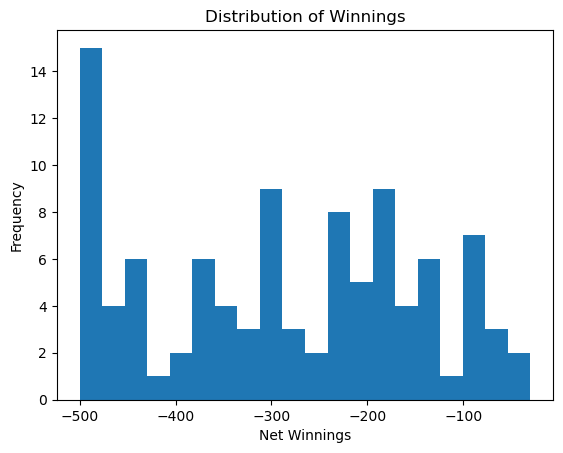


Testing threshold: 1
Average winnings: -313.5
Standard deviation: 148.57
Probability of winning: 0.01
Probability of losing: 0.99


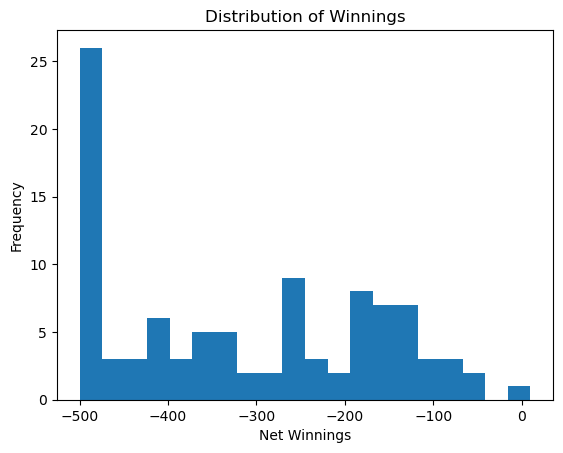

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
    
    def __str__(self):
        return f"{self.rank} of {self.suit}"

class Deck:
    suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
    ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
    values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, 
              '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
    
    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.cards = []
        self.initialize_deck()
    
    def initialize_deck(self):
        self.cards = [Card(suit, rank, self.values[rank]) 
                     for suit in self.suits 
                     for rank in self.ranks] * self.num_decks
        self.shuffle()
        # Place plastic card at random position (last 20% of deck)
        self.plastic_card_pos = random.randint(int(len(self.cards)*0.8), len(self.cards)-1)
    
    def shuffle(self):
        random.shuffle(self.cards)
    
    def draw_card(self):
        if not self.cards or len(self.cards) <= self.plastic_card_pos:
            self.initialize_deck()
        return self.cards.pop()

class Player:
    def __init__(self, name, chips=1000, strategy=None, threshold=0):
        self.name = name
        self.chips = chips
        self.hand = []
        self.bet = 0
        self.count = 0
        self.strategy = strategy
        self.threshold = threshold
    
    def place_bet(self, amount):
        if amount > self.chips:
            return False
        self.bet = amount
        self.chips -= amount
        return True
    
    def receive_card(self, card):
        if card:
            self.hand.append(card)
            self.update_count(card)
    
    def clear_hand(self):
        self.hand = []
        self.bet = 0
    
    def hand_value(self):
        value = sum(card.value for card in self.hand)
        aces = sum(1 for card in self.hand if card.rank == 'A')
        while value > 21 and aces:
            value -= 10
            aces -= 1
        return value
    
    def is_busted(self):
        return self.hand_value() > 21
    
    def has_blackjack(self):
        return len(self.hand) == 2 and self.hand_value() == 21
    
    def update_count(self, card):
        if card.rank in ['2', '3', '4', '5', '6']:
            self.count += 1
        elif card.rank in ['10', 'J', 'Q', 'K', 'A']:
            self.count -= 1
    
    def make_decision(self, dealer_up_card=None):
        if self.strategy == 'counting':
            if self.count <= self.threshold:
                return "hit"
            return "stand"
        elif self.strategy == 'dealer':
            if self.hand_value() < 17:
                return "hit"
            return "stand"
        else:  # Basic strategy
            if self.hand_value() < 12:
                return "hit"
            elif self.hand_value() > 16:
                return "stand"
            elif dealer_up_card and dealer_up_card.value >= 7:
                return "hit" if self.hand_value() < 17 else "stand"
            else:
                return "stand"

class Dealer(Player):
    def __init__(self):
        super().__init__("Dealer")
    
    def play(self, deck):
        while self.hand_value() < 17:
            self.receive_card(deck.draw_card())

class BlackjackGame:
    def __init__(self, num_players=4, verbose=False):
        self.deck = Deck()
        self.dealer = Dealer()
        self.players = []
        self.verbose = verbose
        self.setup_players(num_players)
    
    def setup_players(self, num_players):
        # Add regular players (using dealer strategy)
        for i in range(num_players - 1):
            self.players.append(Player(f"Player {i+1}", 1000, strategy='dealer'))
        
        # Add counting strategy player
        self.players.append(Player("Counting Player", 1000, strategy='counting', threshold=-2))
    
    def deal_initial_cards(self):
        for _ in range(2):
            for player in self.players:
                player.receive_card(self.deck.draw_card())
            self.dealer.receive_card(self.deck.draw_card())
    
    def play_round(self):
        # Players make their decisions
        dealer_up_card = self.dealer.hand[0] if self.dealer.hand else None
        
        for player in self.players:
            if player.chips <= 0:
                continue
                
            player.place_bet(10)  # Fixed bet for simulation
            
            while True:
                decision = player.make_decision(dealer_up_card)
                if decision == "hit":
                    player.receive_card(self.deck.draw_card())
                    if player.is_busted():
                        if self.verbose:
                            print(f"{player.name} busts!")
                        break
                else:
                    break
        
        # Dealer plays
        self.dealer.play(self.deck)
        
        # Determine outcomes
        dealer_value = self.dealer.hand_value()
        dealer_busted = self.dealer.is_busted()
        
        for player in self.players:
            if player.chips <= 0 or player.bet == 0:
                continue
                
            player_value = player.hand_value()
            
            if player.is_busted():
                # Player already lost by busting
                continue
            elif dealer_busted:
                # Player wins unless they also busted
                player.chips += 2 * player.bet
            elif player_value > dealer_value:
                player.chips += 2 * player.bet
            elif player_value == dealer_value:
                player.chips += player.bet  # Push
    
    def reset_round(self):
        for player in self.players:
            player.clear_hand()
        self.dealer.clear_hand()
    
    def simulate(self, num_rounds=50):
        counting_player = self.players[-1]  # Last player is the counting strategy player
        
        for _ in range(num_rounds):
            if counting_player.chips <= 0:
                break
                
            self.deal_initial_cards()
            self.play_round()
            self.reset_round()
        
        return counting_player.chips - 1000  # Return net winnings

def run_simulation(num_games=100, num_rounds=50, threshold=-2):
    results = []
    
    for _ in range(num_games):
        game = BlackjackGame(verbose=False)
        game.players[-1].threshold = threshold  # Set threshold for counting player
        results.append(game.simulate(num_rounds))
    
    return results

def analyze_results(results):
    avg = np.mean(results)
    std = np.std(results)
    win_prob = sum(1 for x in results if x > 0) / len(results)
    loss_prob = sum(1 for x in results if x < 0) / len(results)
    
    print(f"Average winnings: {avg:.1f}")
    print(f"Standard deviation: {std:.2f}")
    print(f"Probability of winning: {win_prob:.2f}")
    print(f"Probability of losing: {loss_prob:.2f}")
    
    plt.hist(results, bins=20)
    plt.title("Distribution of Winnings")
    plt.xlabel("Net Winnings")
    plt.ylabel("Frequency")
    plt.show()

# Main simulation
if __name__ == "__main__":
    # Test different thresholds
    thresholds = [-4, -3, -2, -1, 0, 1]
    
    for threshold in thresholds:
        print(f"\nTesting threshold: {threshold}")
        results = run_simulation(threshold=threshold)
        analyze_results(results)